In [12]:
import requests
from zipfile import ZipFile
import os

os.makedirs('raw_data', exist_ok=True)
url = 'https://osm13.openstreetmap.fr/~cquest/openfla/export/communes-20220101-shp.zip'
response = requests.get(url)

assert response.status_code == 200
with open('raw_data/contour_communes_francaises_100m.zip', 'wb') as file:
    file.write(response.content)
    
unzip = ZipFile('raw_data/contour_communes_francaises_100m.zip')
unzip.extractall('raw_data/contour_communes_francaises_100m')

In [13]:
import geopandas as gpd

communes_fr = gpd.read_file('raw_data/contour_communes_francaises_100m/communes-20220101.shp')
communes_fr

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.20010 42.39013, 9.20014 42.39014, ..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.25119 42.37605, 9.25132 42.37603, ..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.28340 42.66273, 9.28345 42.66273, ..."
...,...,...,...,...,...
34950,80122,Bouquemaison,fr:Bouquemaison,724.0,"POLYGON ((2.31459 50.23489, 2.31746 50.23535, ..."
34951,62795,Sibiville,fr:Sibiville,738.0,"POLYGON ((2.30945 50.31902, 2.30969 50.31913, ..."
34952,62694,Rebreuve-sur-Canche,fr:Rebreuve-sur-Canche,842.0,"POLYGON ((2.32074 50.24767, 2.32077 50.24771, ..."
34953,62831,Troisvaux,fr:Troisvaux,620.0,"POLYGON ((2.32046 50.40520, 2.32137 50.40571, ..."


In [14]:
communes_fr.duplicated(['insee']).sum()

0

In [6]:
from shapely.ops import unary_union

communes_with_contours = communes_fr.groupby(['insee'], as_index=False).agg(
    {
        "geometry": lambda x: unary_union(x),
        "nom": lambda x: "|".join(x)
    })
communes_with_contours

,insee,geometry,nom
0,01001,"POLYGON ((4.90298 46.15828, 4.90299 46.15835, ...",L'Abergement-Clémenciat
1,01002,"POLYGON ((5.40408 46.00793, 5.40434 46.00813, ...",L'Abergement-de-Varey
2,01004,"POLYGON ((5.32722 45.95685, 5.32740 45.95680, ...",Ambérieu-en-Bugey
3,01005,"POLYGON ((4.87552 45.98726, 4.87564 45.98729, ...",Ambérieux-en-Dombes
4,01006,"POLYGON ((5.57068 45.75369, 5.57255 45.75382, ...",Ambléon
...,...,...,...
34950,97613,"MULTIPOLYGON (((45.06612 -12.75987, 45.06613 -...",M'Tsangamouji
34951,97614,"POLYGON ((45.12190 -12.83977, 45.12383 -12.835...",Ouangani
34952,97615,"MULTIPOLYGON (((45.28369 -12.82755, 45.28371 -...",Pamandzi
34953,97616,"MULTIPOLYGON (((45.09253 -12.85161, 45.09253 -...",Sada


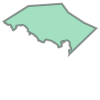

In [9]:
communes_with_contours.loc[34950, 'geometry']

In [11]:
import requests

# stable_url = 'https://www.data.gouv.fr/fr/datasets/r/5ed9b092-a25d-49e7-bdae-0152797c7577'
url = 'https://datanova.laposte.fr/data-fair/api/v1/datasets/laposte-hexasmal/raw'
response = requests.get(url)

assert response.status_code == 200
with open('raw_data/fr_code_postal.csv', 'wb') as file:
    file.write(response.content)

In [17]:
import pandas as pd

code_postal_fr = pd.read_csv('raw_data/fr_code_postal.csv', encoding='cp1252', sep=';')
code_postal_fr.sample(5)

,#Code_commune_INSEE,Nom_de_la_commune,Code_postal,Libellé_d_acheminement,Ligne_5
33139,76508,LA POTERIE CAP D ANTIFER,76280,LA POTERIE CAP D ANTIFER,NaN
4143,11246,MONTGRADAIL,11240,MONTGRADAIL,NaN
35396,81002,AIGUEFONDE,81200,AIGUEFONDE,NaN
24523,59068,BERLAIMONT,59145,BERLAIMONT,NaN
37573,88510,VILLOTTE,88320,VILLOTTE,NaN


In [111]:
merged_df = communes_fr.merge(code_postal_fr[['#Code_commune_INSEE', 'Code_postal']], 
                              how='left', left_on='insee', right_on='#Code_commune_INSEE',
                             )
merged_df.rename(columns={'Code_postal': 'zip_code'}, inplace=True)
merged_df.drop('#Code_commune_INSEE', axis=1, inplace=True)
merged_df.set_index('insee', drop=False, inplace=True)
# Cities with districts or cities that have merged with others
insee_to_special_zip_code = {
    '13055': '13000',
    '69123': '69000',
    '51063': '51700',
    '71492': '71460',
    '01039': '01350',
    '51637': '51700',
    '16140': '16230',
    '09255': '09100'
}
for (k, v) in insee_to_special_zip_code.items():
    merged_df.loc[k, 'zip_code'] = v
    
# merged_df.dropna(subset=['zip_code'], inplace=True)
merged_df.zip_code = merged_df.zip_code.astype(int)
merged_df.reset_index(drop=True, inplace=True)
merged_df

ValueError: cannot convert float NaN to integer

In [112]:
merged_df[merged_df.nom.apply(lambda x: 'paris' in x.lower())]

,insee,nom,wikipedia,surf_ha,geometry,zip_code
insee,,,,,,
38485,38485,Seyssinet-Pariset,fr:Seyssinet-Pariset,1078.0,"POLYGON ((5.63864 45.15350, 5.63886 45.15434, ...",38170.0
39189,39189,Damparis,fr:Damparis,895.0,"POLYGON ((5.36102 47.07591, 5.36207 47.07670, ...",39500.0
71343,71343,Paris-l'Hôpital,fr:Paris-l'Hôpital,275.0,"POLYGON ((4.62839 46.90759, 4.62841 46.90787, ...",71150.0
95176,95176,Cormeilles-en-Parisis,fr:Cormeilles-en-Parisis,844.0,"POLYGON ((2.17335 48.95349, 2.17398 48.95391, ...",95240.0
81202,81202,Parisot,fr:Parisot (Tarn),2871.0,"POLYGON ((1.78504 43.80676, 1.78506 43.80678, ...",81310.0
82137,82137,Parisot,fr:Parisot (Tarn-et-Garonne),2822.0,"POLYGON ((1.81972 44.28128, 1.81976 44.28131, ...",82160.0
62826,62826,Le Touquet-Paris-Plage,fr:Le Touquet-Paris-Plage,1528.0,"POLYGON ((1.57614 50.48773, 1.57616 50.48790, ...",62520.0
77514,77514,Villeparisis,fr:Villeparisis,842.0,"POLYGON ((2.59139 48.95008, 2.59142 48.95030, ...",77270.0
75056,75056,Paris,fr:Paris,10539.0,"POLYGON ((2.22412 48.85420, 2.22416 48.85461, ...",NaN


In [105]:
merged_df.to_file('data/fr_communes_contours.shp')